
# FinShield – Detección de fraude con redes densas (PyTorch)

Dataset: `finshield_transactions.csv` (10k transacciones simuladas)
Objetivo: clasificar `fraud_label` (0/1) a partir de variables tabulares.

Pasos: carga de datos, *preprocessing* (One-Hot/StandardScaler), `DataLoader`, red densa, `CrossEntropyLoss`, `Adam`, *early stopping* simple y métricas.


In [ ]:
import pandas as pd, numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)


df = pd.read_csv("finshield_transactions.csv")
num_cols = ["amount","hour","weekday","is_night","past_24h_txn_count","past_1h_txn_count","user_avg_amount","merchant_chargeback_rate"]
cat_cols = ["merchant_category","device_type","country"]

y = df["fraud_label"].values.astype("int64")
X = df[num_cols + cat_cols]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



pre = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

pipe = Pipeline([("pre", pre)])
X_train_t = pipe.fit_transform(X_train)
X_val_t = pipe.transform(X_val)


# Guardo el modelo para asegurar repetibilidad
joblib.dump(pipe, "finshield_preprocessor.joblib")

['finshield_preprocessor.joblib']

[Clásico] ROC AUC (validación): 0.693
              precision    recall  f1-score   support

           0      0.870     0.999     0.930      1739
           1      0.667     0.008     0.015       261

    accuracy                          0.870      2000
   macro avg      0.768     0.504     0.473      2000
weighted avg      0.844     0.870     0.811      2000



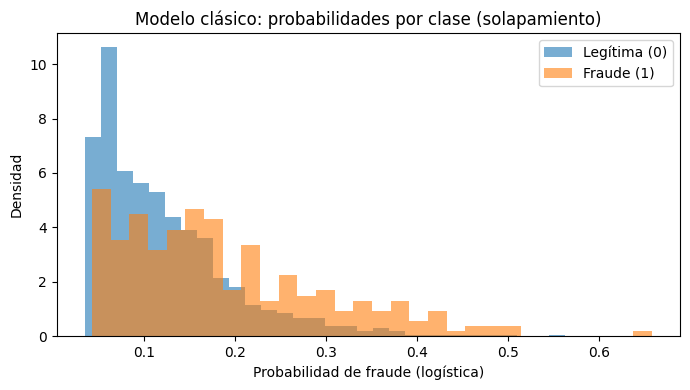

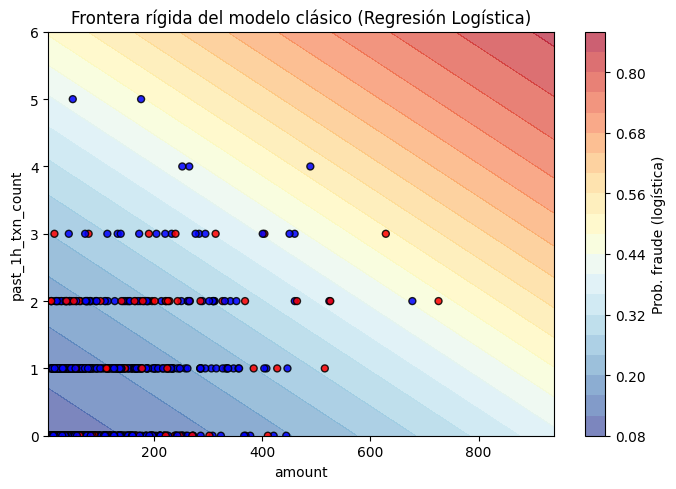

In [ ]:
# BLOQUE 1 — Modelo clásico

def _to_dense(a):
    return a.toarray() if hasattr(a, "toarray") else a

# ---- 1) Entrenar Regresión Logística sobre TODAS las features preprocesadas ----
# Recalculamos matrices densas desde el pipe
Xtr_np = _to_dense(pipe.transform(X_train)).astype(np.float32)
Xva_np = _to_dense(pipe.transform(X_val)).astype(np.float32)

logit = LogisticRegression(max_iter=500)
logit.fit(Xtr_np, y_train)
proba_val = logit.predict_proba(Xva_np)[:, 1]

auc = roc_auc_score(y_val, proba_val)
print(f"[Clásico] ROC AUC (validación): {auc:.3f}")

preds_05 = (proba_val >= 0.5).astype(int)
print(classification_report(y_val, preds_05, digits=3))

# Distribución de probabilidades por clase (solapamiento)
plt.figure(figsize=(7,4))
plt.hist(proba_val[y_val==0], bins=30, alpha=0.6, label="Legítima (0)", density=True)
plt.hist(proba_val[y_val==1], bins=30, alpha=0.6, label="Fraude (1)",   density=True)
plt.xlabel("Probabilidad de fraude (logística)")
plt.ylabel("Densidad")
plt.title("Modelo clásico: probabilidades por clase (solapamiento)")
plt.legend()
plt.tight_layout()
plt.show()

#  Visual 2: Frontera 2D rígida (amount vs past_1h_txn_count) ----
features_2d = ["amount", "past_1h_txn_count"]
X2 = df[features_2d].values
y2 = df["fraud_label"].values

pipe_2d = Pipeline([
    ("scaler", StandardScaler()),
    ("logit", LogisticRegression(max_iter=500))
])
pipe_2d.fit(X2, y2)

# Malla 2D
x_min, x_max = X2[:, 0].min(), X2[:, 0].max()
y_min, y_max = X2[:, 1].min(), X2[:, 1].max()
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]
Z = pipe_2d.predict_proba(grid)[:, 1].reshape(xx.shape)

sample = df.sample(min(1200, len(df)), random_state=42)

plt.figure(figsize=(7,5))
cont = plt.contourf(xx, yy, Z, levels=20, cmap="RdYlBu_r", alpha=0.65)
plt.colorbar(cont, label="Prob. fraude (logística)")
plt.scatter(sample["amount"], sample["past_1h_txn_count"],
            c=sample["fraud_label"], cmap="bwr", edgecolor="k", s=25, alpha=0.85)
plt.xlabel("amount")
plt.ylabel("past_1h_txn_count")
plt.title("Frontera rígida del modelo clásico (Regresión Logística)")
plt.tight_layout()
plt.show()


## Red densa y entrenamiento

Aquí tuvimos en esta métrica el mejor valor en el primer epoch, pero la red todavía es muy simple como para mejorar el resultado de la regresión logística.

## Evaluación final

Época 001 | Pérdida=0.7234 | AUC=0.544
Época 002 | Pérdida=0.7153 | AUC=0.540
Época 003 | Pérdida=0.7083 | AUC=0.536
Época 004 | Pérdida=0.7012 | AUC=0.531
Época 005 | Pérdida=0.6945 | AUC=0.524
Época 006 | Pérdida=0.6876 | AUC=0.518
Época 007 | Pérdida=0.6816 | AUC=0.512
Época 008 | Pérdida=0.6756 | AUC=0.505
Época 009 | Pérdida=0.6694 | AUC=0.497
Época 010 | Pérdida=0.6647 | AUC=0.489
Época 011 | Pérdida=0.6584 | AUC=0.480
Época 012 | Pérdida=0.6535 | AUC=0.473
Época 013 | Pérdida=0.6485 | AUC=0.468
Época 014 | Pérdida=0.6439 | AUC=0.463
Época 015 | Pérdida=0.6389 | AUC=0.458
Época 016 | Pérdida=0.6337 | AUC=0.454
Época 017 | Pérdida=0.6289 | AUC=0.451
Época 018 | Pérdida=0.6237 | AUC=0.449
Época 019 | Pérdida=0.6194 | AUC=0.447
Época 020 | Pérdida=0.6144 | AUC=0.446
Época 021 | Pérdida=0.6100 | AUC=0.446
Época 022 | Pérdida=0.6058 | AUC=0.445
Época 023 | Pérdida=0.6008 | AUC=0.445
Época 024 | Pérdida=0.5959 | AUC=0.445
Época 025 | Pérdida=0.5911 | AUC=0.445
Época 026 | Pérdida=0.586

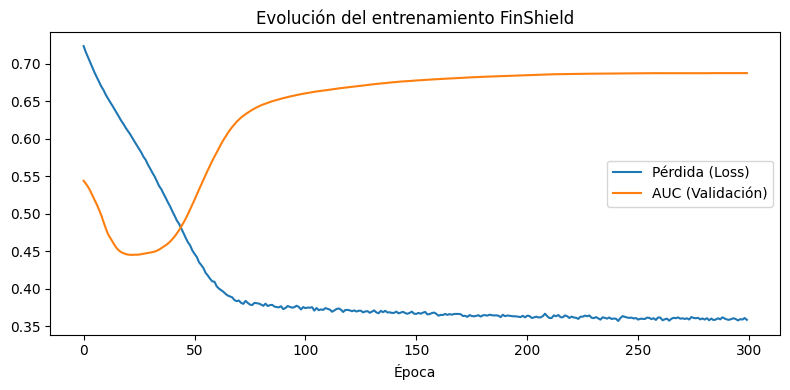

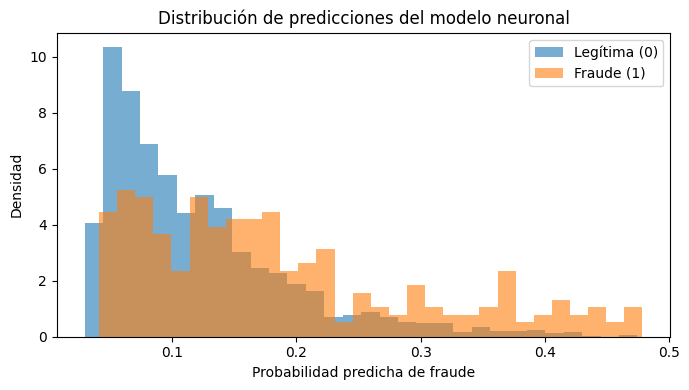

In [ ]:
# BLOQUE 2 — Red neuronal simple en PyTorch

df = pd.read_csv("finshield_transactions.csv")
num_cols = ["amount","hour","weekday","is_night","past_24h_txn_count",
            "past_1h_txn_count","user_avg_amount","merchant_chargeback_rate"]
cat_cols = ["merchant_category","device_type","country"]
y = df["fraud_label"].astype("int64").values
X = df[num_cols + cat_cols]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

# --- 2) Preprocesamiento ---
pre = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])
pipe = Pipeline([("pre", pre)])
X_train_t = pipe.fit_transform(X_train)
X_val_t = pipe.transform(X_val)
joblib.dump(pipe, "finshield_preprocessor.joblib")

# --- 3) Tensores ---
X_train_t = torch.tensor(
    X_train_t.toarray() if hasattr(X_train_t, "toarray") else X_train_t,
    dtype=torch.float32)
X_val_t = torch.tensor(
    X_val_t.toarray() if hasattr(X_val_t, "toarray") else X_val_t,
    dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_val_t = torch.tensor(y_val, dtype=torch.long)

# --- 4) Red neuronal (dos capas ocultas) ---
class SimpleNN(nn.Module):
    def __init__(self, n_inputs):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.net(x)

model = SimpleNN(X_train_t.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

# --- 5) Entrenamiento con early stopping ---
best_auc, bad, patience = 0, 0, 10
losses, aucs = [], []

for epoch in range(300):
    model.train()
    logits = model(X_train_t)
    loss = criterion(logits, y_train_t)
    optimizer.zero_grad(); loss.backward(); optimizer.step()

    model.eval()
    with torch.no_grad():
        val_logits = model(X_val_t)
        val_probs = torch.softmax(val_logits, dim=1)[:, 1].numpy()
        val_auc = roc_auc_score(y_val, val_probs)
    losses.append(loss.item()); aucs.append(val_auc)
    print(f"Época {epoch+1:03d} | Pérdida={loss.item():.4f} | AUC={val_auc:.3f}")

    if val_auc > best_auc + 1e-4:
        best_auc, bad = val_auc, 0
        torch.save(model.state_dict(), "finshield_best.pt")
    else:
        bad += 1
"""    if bad >= patience:
        print("Early stopping: sin mejora en validación.")
        break"""

print(f"\nMejor AUC alcanzado: {best_auc:.3f}")

# --- 6) Visualización ---
plt.figure(figsize=(8,4))
plt.plot(losses, label="Pérdida (Loss)")
plt.plot(aucs, label="AUC (Validación)")
plt.xlabel("Época"); plt.title("Evolución del entrenamiento FinShield")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.hist(val_probs[y_val==0], bins=30, alpha=0.6, label="Legítima (0)", density=True)
plt.hist(val_probs[y_val==1], bins=30, alpha=0.6, label="Fraude (1)", density=True)
plt.xlabel("Probabilidad predicha de fraude")
plt.ylabel("Densidad")
plt.title("Distribución de predicciones del modelo neuronal")
plt.legend(); plt.tight_layout(); plt.show()


Aquí la red se acercó bastante al valor anterior pero para justificar su uso el resultado debería ser superior debido a su complejidad mayor.

Época 001 | Loss=0.7162 | AUC=0.616
Época 002 | Loss=0.6964 | AUC=0.650
Época 003 | Loss=0.6884 | AUC=0.665
Época 004 | Loss=0.6686 | AUC=0.673
Época 005 | Loss=0.6548 | AUC=0.679
Época 006 | Loss=0.6439 | AUC=0.682
Época 007 | Loss=0.6292 | AUC=0.684
Época 008 | Loss=0.6178 | AUC=0.684
Época 009 | Loss=0.6122 | AUC=0.684
Época 010 | Loss=0.5985 | AUC=0.684
Época 011 | Loss=0.5890 | AUC=0.684
Época 012 | Loss=0.5784 | AUC=0.684
Época 013 | Loss=0.5674 | AUC=0.684
Época 014 | Loss=0.5578 | AUC=0.684
Época 015 | Loss=0.5493 | AUC=0.684
Época 016 | Loss=0.5421 | AUC=0.684
Época 017 | Loss=0.5349 | AUC=0.684
Época 018 | Loss=0.5278 | AUC=0.684
Época 019 | Loss=0.5183 | AUC=0.684
Época 020 | Loss=0.5109 | AUC=0.684
Época 021 | Loss=0.5078 | AUC=0.684
Época 022 | Loss=0.5022 | AUC=0.684
Época 023 | Loss=0.4925 | AUC=0.685
Época 024 | Loss=0.4865 | AUC=0.685
Época 025 | Loss=0.4797 | AUC=0.685
Época 026 | Loss=0.4776 | AUC=0.686
Época 027 | Loss=0.4735 | AUC=0.686
Época 028 | Loss=0.4649 | AU

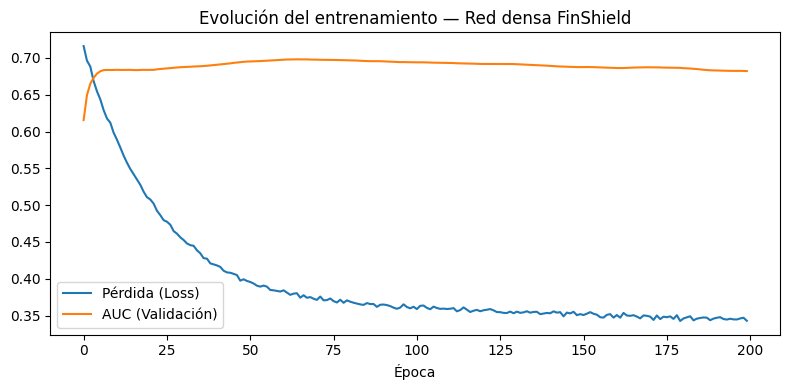

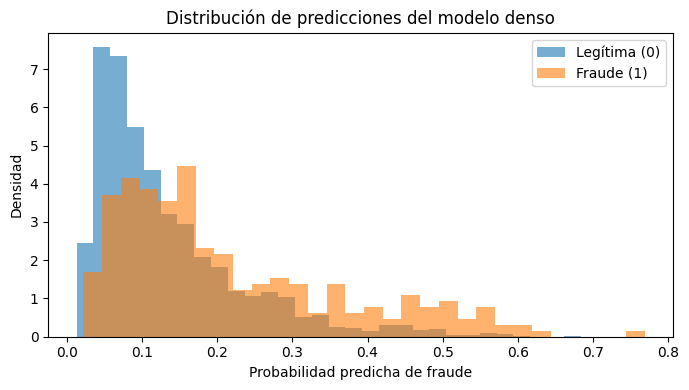

In [ ]:
df = pd.read_csv("finshield_transactions.csv")
num_cols = ["amount","hour","weekday","is_night","past_24h_txn_count",
            "past_1h_txn_count","user_avg_amount","merchant_chargeback_rate"]
cat_cols = ["merchant_category","device_type","country"]
y = df["fraud_label"].astype("int64").values
X = df[num_cols + cat_cols]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

# --- 2) Preprocesamiento ---
pre = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])
pipe = Pipeline([("pre", pre)])
X_train_t = pipe.fit_transform(X_train)
X_val_t = pipe.transform(X_val)
joblib.dump(pipe, "finshield_preprocessor.joblib")

# --- 3) Tensores ---
X_train_t = torch.tensor(
    X_train_t.toarray() if hasattr(X_train_t, "toarray") else X_train_t,
    dtype=torch.float32)
X_val_t = torch.tensor(
    X_val_t.toarray() if hasattr(X_val_t, "toarray") else X_val_t,
    dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_val_t = torch.tensor(y_val, dtype=torch.long)

# --- 4) Red densa más profunda ---
class DenseNN(nn.Module):
    def __init__(self, n_inputs):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 2)
        )
    def forward(self, x):
        return self.net(x)

model = DenseNN(X_train_t.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)

# --- 5) Entrenamiento con early stopping ---
best_auc, bad, patience = 0, 0, 12
losses, aucs = [], []

for epoch in range(200):
    model.train()
    logits = model(X_train_t)
    loss = criterion(logits, y_train_t)
    optimizer.zero_grad(); loss.backward(); optimizer.step()

    model.eval()
    with torch.no_grad():
        val_logits = model(X_val_t)
        val_probs = torch.softmax(val_logits, dim=1)[:, 1].numpy()
        val_auc = roc_auc_score(y_val, val_probs)
    losses.append(loss.item()); aucs.append(val_auc)
    print(f"Época {epoch+1:03d} | Loss={loss.item():.4f} | AUC={val_auc:.3f}")

    if val_auc > best_auc + 1e-4:
        best_auc, bad = val_auc, 0
        torch.save(model.state_dict(), "finshield_best_dense.pt")
    else:
        bad += 1
"""    if bad >= patience:
        print("Early stopping: sin mejora en validación.")
        break"""

print(f"\n🏁 Mejor AUC alcanzado: {best_auc:.3f}")

# --- 6) Visualizaciones ---
plt.figure(figsize=(8,4))
plt.plot(losses, label="Pérdida (Loss)")
plt.plot(aucs, label="AUC (Validación)")
plt.xlabel("Época"); plt.title("Evolución del entrenamiento — Red densa FinShield")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.hist(val_probs[y_val==0], bins=30, alpha=0.6, label="Legítima (0)", density=True)
plt.hist(val_probs[y_val==1], bins=30, alpha=0.6, label="Fraude (1)", density=True)
plt.xlabel("Probabilidad predicha de fraude")
plt.ylabel("Densidad")
plt.title("Distribución de predicciones del modelo denso")
plt.legend(); plt.tight_layout(); plt.show()


En este caso al aumentar la complejidad de la red aumentó la métrica hasta 0.698, un valor que probablemente no justifique su aplicación ya que es más compleja, más costosa computacionalmente, más lenta, etc.

Queda plasmado que el modelo no sólo por ser más complejo, va a ser mejor.